In [1]:
import numpy as np
from itertools import islice, chain
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import MobileNet
from keras.layers import Dense, Flatten, GlobalAvgPool2D
from keras.models import Model
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Setup data loading
data_directory = "/data/Space.10"
target_size = (224,224)
batch_size = 8
test_generator = ImageDataGenerator(rescale=1/255).flow_from_directory(data_directory, shuffle=False,
            class_mode=None, target_size=target_size, batch_size=batch_size)

training_augmenter = ImageDataGenerator(rescale=1/255)

training_generator = training_augmenter.flow_from_directory(data_directory, target_size=target_size,
            class_mode="categorical", batch_size=batch_size)

validation_generator = training_augmenter.flow_from_directory(data_directory, target_size=target_size,
            class_mode="categorical", batch_size=batch_size)

# Patch keras ImageDataGenerator to allow training/validation split
def flow_index(ixes, batch_size, shuffle=False):
    while True:
        ix = np.random.permutation(ixes)
        
        ixstart = range(0,19,5)
        ixend = chain(range(0,19,5),(19,))
        next(ixend)
        for ixs, ixe in zip(ixstart, ixend):
            yield ix[ixs:ixe]

# Find indexes for training and validation
indexes = np.random.permutation(np.arange(training_generator.n))

samples = training_generator.samples
test_split = 0.8
ixsplit = int(samples*test_split)

# Calculate number of batches in each
test_spe = int(np.ceil(test_generator.samples/test_generator.batch_size))
training_spe = int(np.ceil(ixsplit/training_generator.batch_size))
validation_spe = int(np.ceil((samples-ixsplit)/training_generator.batch_size))
#training_spe = test_spe
#validation_spe = test_spe
# Apply patch
training_generator._flow_index = flow_index(indexes[:ixsplit], training_generator.batch_size)
validation_generator._flow_index = flow_index(indexes[ixsplit:], validation_generator.batch_size)


Found 95 images belonging to 2 classes.
Found 95 images belonging to 2 classes.
Found 95 images belonging to 2 classes.


In [193]:
# List classes
training_generator.class_indices

{'almindelig': 0, 'chokolade': 1}

In [ ]:
# Load Pretrained model
model = MobileNet(include_top=False)

# Freeze pretrained model
for layer in model.layers:
    layer.trainable = False

# Remember input
model_input = model.input

# Attatch classification top

model = GlobalAvgPool2D(model(model_input))
model = Dense(128, activation="relu")(model)
model = Dense(len(training_generator.class_indices), activation="softmax")(model)

# Collect and Compile
model = Model(model_input, model)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [195]:
# Fit NN model
model.fit_generator(training_generator, epochs=10, steps_per_epoch=training_spe,
                    validation_data=validation_generator, validation_steps=validation_spe)

Epoch 1/10
9/9 [==============================] - 11s - loss: 1.5050 - acc: 0.8611 - val_loss: 7.0517 - val_acc: 0.5625
Epoch 2/10
9/9 [==============================] - 10s - loss: 1.6744 - acc: 0.8869 - val_loss: 2.3446 - val_acc: 0.8125
Epoch 3/10
9/9 [==============================] - 10s - loss: 0.7059 - acc: 0.9444 - val_loss: 3.2529 - val_acc: 0.7500
Epoch 4/10
9/9 [==============================] - 10s - loss: 0.7105 - acc: 0.9565 - val_loss: 6.0700 - val_acc: 0.5625
Epoch 5/10
9/9 [==============================] - 10s - loss: 0.2240 - acc: 0.9861 - val_loss: 3.0221 - val_acc: 0.8125
Epoch 6/10
9/9 [==============================] - 10s - loss: 1.1456 - acc: 0.9287 - val_loss: 2.0148 - val_acc: 0.8750
Epoch 7/10
9/9 [==============================] - 10s - loss: 0.9255 - acc: 0.9426 - val_loss: 5.0369 - val_acc: 0.6875
Epoch 8/10
4/9 [============>.................] - ETA: 4s - loss: 1.0074 - acc: 0.9375  

KeyboardInterrupt: 

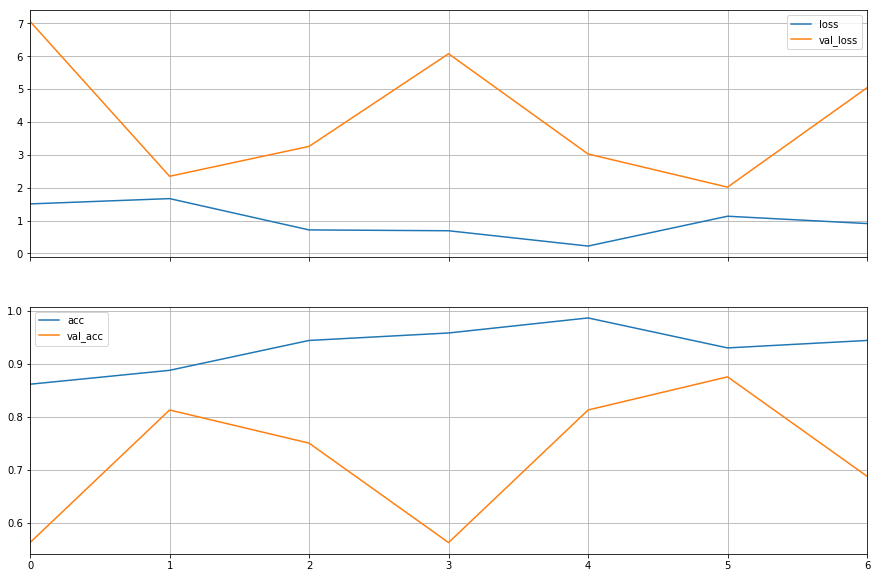

In [196]:
def plot_hist(history, series, ax=None):
    if ax is None:
        ax = plt.gca()
    for s in series:
        ax.plot(history.epoch, history.history[s])
    ax.grid(True)
    ax.autoscale(enable=True, axis='x', tight=True)
    ax.legend(series)

fig, ax = plt.subplots(2,1, sharex=True, figsize=(15,10))
plot_hist(model.history, ['loss', 'val_loss'], ax[0])
plot_hist(model.history, ['acc', 'val_acc'], ax[1])

In [211]:
predicted_class = np.argmax(model.predict_generator(test_generator, steps=test_spe, verbose=1), axis=1)

12/12 [==============================] - 11s    


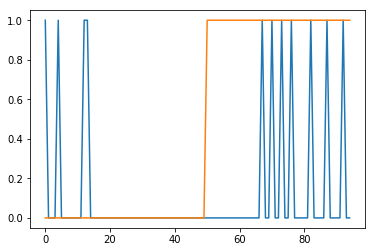

In [212]:
plt.plot(predicted_class)
plt.plot(test_generator.classes)

In [206]:
test_generator.batch_index

10

In [166]:
next(test_generator)


array([[[[ 0.83529419,  0.83921576,  0.80784321],
         [ 0.83529419,  0.83921576,  0.80784321],
         [ 0.83921576,  0.84313732,  0.81176478],
         ..., 
         [ 0.91764712,  0.92156869,  0.89803928],
         [ 0.91764712,  0.92156869,  0.89803928],
         [ 0.91764712,  0.92156869,  0.89803928]],

        [[ 0.83529419,  0.83921576,  0.80784321],
         [ 0.83529419,  0.83921576,  0.80784321],
         [ 0.83921576,  0.84313732,  0.81176478],
         ..., 
         [ 0.91764712,  0.92156869,  0.89803928],
         [ 0.91764712,  0.92156869,  0.89803928],
         [ 0.91764712,  0.92156869,  0.89803928]],

        [[ 0.83529419,  0.83921576,  0.80784321],
         [ 0.83529419,  0.83921576,  0.80784321],
         [ 0.83921576,  0.84313732,  0.81176478],
         ..., 
         [ 0.92156869,  0.92549026,  0.90196085],
         [ 0.91764712,  0.92156869,  0.89803928],
         [ 0.91764712,  0.92156869,  0.89803928]],

        ..., 
        [[ 0.77647066,  0.73725492,

In [214]:
# Tekster
# Tensorflow graf

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenet_1.00_224 (Model)   (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_10 (Flatten)         (None, 50176)             0         
_________________________________________________________________
dense_14 (Dense)             (None, 128)               6422656   
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 258       
Total params: 9,651,778
Trainable params: 6,422,914
Non-trainable params: 3,228,864
_________________________________________________________________


In [ ]:
# Deeplearning hurtigt på lidt data
# Pretrained
# Data augmentation
# Effective models